In [1]:
# basics
import numpy as np
import pandas as pd
import networkx as nx
import datetime as dt

# network communities
import infomap

# shapefiles
import geopandas as gpd

# plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from collections import Counter
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

In [3]:
month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                   4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2019-10-03', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
date_dict = dict(zip(DATERANGE,list(range(len(DATERANGE)))))

DATE_DF = DATE_DF.merge(DATE_DF.loc[DATE_DF['day']=='Sunday'
                                   ].rename(columns={'date':'week_of'
                                })[['week_of','week']], how='left', on='week')
DATE_DF_w = DATE_DF.loc[DATE_DF['day']=='Sunday'][['week_of','week']]

# Step 1a: Load in flow data

In [4]:
fn_uk_base = '../data/google_converted_movements.csv' ##not able to share due to data privacy issues
uk_df = pd.read_csv(fn_uk_base).iloc[:,1:]
uk_df['week_of'] = [i.split('/')[2]+'-'+i.split('/')[1]+'-'+i.split('/')[0]
                    for i in uk_df['week_start'].values]

uk_df = uk_df[['week_of','origin','destination',
                 'movement','converted_movements']].merge(DATE_DF_w,
                                                  how='left', on='week_of')
uk_df = uk_df.loc[uk_df['week']>0].copy()
uk_df = uk_df.sort_values(['week_of','origin']).reset_index().iloc[:,1:]
uk_df = uk_df[['week_of','week','origin','destination',
                 'movement','converted_movements']].copy()

mun_nodes = np.unique(uk_df['origin'].str[:].tolist() +\
                      uk_df['destination'].str[:].tolist())
mun_relabel = dict(zip(mun_nodes, list(range(len(mun_nodes)))))
relabel_mun = {j:i for i,j in mun_relabel.items()}

# Step 1b: Shapefile of UK, with subregions

In [5]:
gdf = gpd.read_file('../data/Local_Authority_Districts_(December_2019)_Boundaries_UK_BFC/')
gdf = gdf.rename(columns = {'lad19cd':'origin','lad19nm':'origin_name'})
gdf['centroid'] = gdf['geometry'].centroid

manchester_ix = ['E06000006', 'E06000007', 'E06000008', 'E06000009',
                 'E07000037', 'E07000117', 'E07000118', 'E07000119',
                 'E07000120', 'E07000121', 'E07000122', 'E07000123',
                 'E07000124', 'E07000125', 'E07000126', 'E07000127',
                 'E07000128', 'E07000163', 'E08000001', 'E08000002',
                 'E08000003', 'E08000004', 'E08000005', 'E08000006',
                 'E08000007', 'E08000008', 'E08000009', 'E08000010',
                 'E08000011', 'E08000012', 'E08000013', 'E08000014',
                 'E08000015', 'E08000032', 'E08000033']
london_ix = ['E06000034', 'E07000068', 'E07000098', 'E07000102',
             'E07000103', 'E07000107', 'E07000111', 'E07000115',
             'E07000207', 'E07000208', 'E07000212', 'E07000213',
             'E09000001', 'E09000002', 'E09000003', 'E09000004',
             'E09000005', 'E09000006', 'E09000007', 'E09000008',
             'E09000009', 'E09000010', 'E09000011', 'E09000012',
             'E09000013', 'E09000014', 'E09000015', 'E09000016',
             'E09000017', 'E09000018', 'E09000019', 'E09000020',
             'E09000021', 'E09000022', 'E09000023', 'E09000024',
             'E09000025', 'E09000026', 'E09000027', 'E09000028',
             'E09000029', 'E09000030', 'E09000031', 'E09000032', 'E09000033']
scotland_ix = ['S12000005', 'S12000008', 'S12000010', 'S12000011', 'S12000014',
               'S12000018', 'S12000019', 'S12000021', 'S12000026', 'S12000029',
               'S12000030', 'S12000036', 'S12000038', 'S12000039', 'S12000040',
               'S12000045', 'S12000047', 'S12000049', 'S12000050']

# Step 2: Construct graphs from flow data

In [6]:
def get_infomap_communities(G, level='--two-level'):
    """
    Wrapper to get infomap communities from the infomap package.
    """
    infomapX = infomap.Infomap(level)
    for e in list(G.edges()):
        infomapX.network.addLink(*e)

    infomapX.run();

    comms = {}
    for node in infomapX.iterLeafNodes():
        comms[node.physicalId] = node.moduleIndex()
    
    return comms

g_dict_w = {}
p_dict_w_inf = {}

for w in sorted(uk_df.week_of.unique()[1:]):  # span through all the weeks in the data
    # for each week, make a new network---we're gonna add this to the dictionary above
    df_w = uk_df.loc[uk_df['week_of']==w].copy()
    G_w = nx.DiGraph()
    G_w.add_nodes_from(mun_nodes)
    wel_w = [(df_w['origin'].values[i],
              df_w['destination'].values[i],
              df_w['movement'].values[i]) for i in range(df_w.shape[0])]
    G_w.add_weighted_edges_from(wel_w)
    G_w_rl = nx.relabel_nodes(G_w, mun_relabel)
    # add the networkx object to the dictionary storing all the networks
    g_dict_w[w] = G_w  

    # for each week's network, let's get the Infomap communities
    partition_informap_w = get_infomap_communities(G_w_rl)
    p_dict_w_inf[w] = {relabel_mun[i]:j for i,j in partition_informap_w.items()}
    
ref_weeks = [11,12,13,14,15,16,17,18,19,20]
week_df = uk_df[['week','week_of']].drop_duplicates()
week_dict = dict(zip(week_df['week'].values,week_df['week_of']))

uk_df_ref = uk_df.loc[uk_df['week'].isin(ref_weeks)].groupby(['origin','destination']
                              ).agg({'movement':np.nanmean,
                                     'converted_movements':np.nanmean}).reset_index()

G_ref = nx.DiGraph()
G_ref.add_nodes_from(mun_nodes)
wel_ref = [(uk_df_ref['origin'].values[i],
            uk_df_ref['destination'].values[i],
            uk_df_ref['movement'].values[i]) for i in range(uk_df_ref.shape[0])]
G_ref.add_weighted_edges_from(wel_ref)
G_ref_rl = nx.relabel_nodes(G_ref, mun_relabel)

# for each week's network, let's get the Infomap communities
partition_informap_ref = get_infomap_communities(G_ref_rl)
partition_informap_ref = {relabel_mun[i]:j
                          for i,j in partition_informap_ref.items()}

gdfx = gdf.merge(pd.DataFrame({"origin":list(partition_informap_ref.keys()),
                               "comm":list(partition_informap_ref.values())}),
                 how='left', on='origin')

# Step 3: Main figure, highlighting links from London

/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


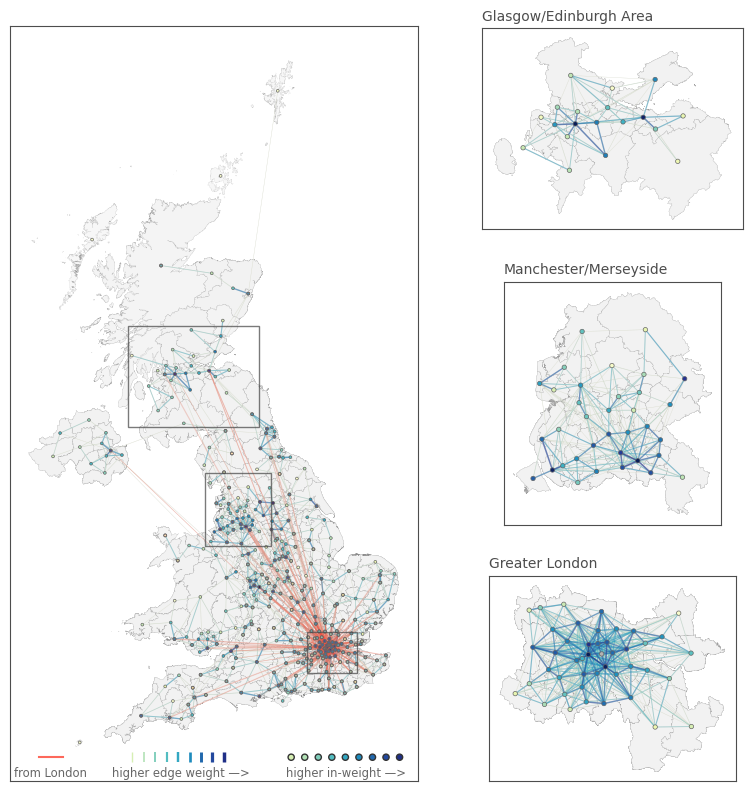

In [7]:
col = '#FD685B'
colX = [0.992, 0.318, 0.259, 0.9]

cmaa = plt.cm.YlGnBu_r
wx = 57
wi = uk_df['week_of'].unique()[wx]
w = 10; h = 10
fig = plt.figure(figsize=(w,h),dpi=100)

gs = GridSpec(6, 6, figure=fig, height_ratios=[0.6,1,1,1,1,0.6],
              width_ratios=[-0.45,2,1,1,1,1])

ax00 = fig.add_subplot(gs[0:6, 0:4])
ax04 = fig.add_subplot(gs[0:2, 4:6])
ax03 = fig.add_subplot(gs[2:4, 4:6])
ax02 = fig.add_subplot(gs[4:6, 4:6])

# ax00.set_title('United Kingdon, local authority districts\n'+\
#                '(week starting 29 November, 2020)',
#            ha='left',x=0, fontsize='large', color='.3')

mov_gw = uk_df.loc[uk_df['week_of']==wi].copy()
mov_gw['sizes'] = (np.log(mov_gw['movement'])-np.log(mov_gw['movement']).min()+1).values

uk_shp = gdf.copy()
uk_shp = uk_shp.merge(mov_gw[['origin','sizes']], how='left', on='origin')

lo_shp = uk_shp.loc[uk_shp['origin'].isin(london_ix)].copy()
ma_shp = uk_shp.loc[uk_shp['origin'].isin(manchester_ix)].copy()
sc_shp = uk_shp.loc[uk_shp['origin'].isin(scotland_ix)].copy()

uk_map = uk_shp.plot(ax=ax00, fc='.95', ec='.55', lw=0.1, alpha=0.6,zorder=0)
lo_map = lo_shp.plot(ax=ax02, fc='.95', ec='.55', lw=0.1, alpha=0.6)
ma_map = ma_shp.plot(ax=ax03, fc='.95', ec='.55', lw=0.1, alpha=0.6)
sc_map = sc_shp.plot(ax=ax04, fc='.95', ec='.55', lw=0.1, alpha=0.6)

uk_map.set_rasterized(True)
lo_map.set_rasterized(True)
ma_map.set_rasterized(True)
sc_map.set_rasterized(True)

pos_mun = {gdf['origin'].values[i]:(gdf['centroid'].values[i].x, 
                                    gdf['centroid'].values[i].y)
           for i in range(gdf.shape[0])}

G_ref = nx.DiGraph()
G_ref.add_nodes_from(mun_nodes)
wel_ref = [(mov_gw['origin'].values[i],
            mov_gw['destination'].values[i],
            mov_gw['movement'].values[i]) for i in range(mov_gw.shape[0])]
G_ref.add_weighted_edges_from(wel_ref)
G_ref_rl = nx.relabel_nodes(G_ref, mun_relabel)

# for each week's network, let's get the Infomap communities
partition_informap_ref = get_infomap_communities(G_ref_rl)
partition_informap_ref = {relabel_mun[i]:j
                          for i,j in partition_informap_ref.items()}
Gcc_w = G_ref.to_undirected()

nsb = 5
tmp_nc = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                       for i in list(G_ref.edges(data=True))],
                      columns=['origin','destination','movement'])
ncw_df = tmp_nc.groupby('destination').agg({'movement':'sum'}).reset_index()
ncw = dict(zip(ncw_df['destination'].values,ncw_df['movement'].values))
nc_w = np.array(list(ncw.values()))
ncw_w = np.log(nc_w) - np.quantile(np.log(nc_w),.2) + 1
ncw_w[ncw_w<0] = 0
ncw_w = cmaa(((np.nanmax(ncw_w)-ncw_w)/(np.nanmax(ncw_w)-np.nanmin(ncw_w)))-0.05)
ncw = dict(zip(ncw_df['destination'].values,ncw_w))
ncw = {i:ncw[i] if i in list(ncw.keys()) else '.8' for i in list(Gcc_w.nodes())}

nc_w = [ncw[i] for i in list(Gcc_w.nodes())]
ns_w = [nsb-1 for i in list(Gcc_w.nodes())]

tmp_ew = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                       for i in list(Gcc_w.edges(data=True))],
                      columns=['origin','destination','movement'])
tmp_ew = tmp_ew.sort_values('movement').reset_index().iloc[:,1:]
ord_el = list(zip(tmp_ew['origin'].values,tmp_ew['destination'].values))

ew_dict = nx.get_edge_attributes(Gcc_w, 'weight')
ew_dict = {i:ew_dict[i] for i in ord_el}
ew_w = np.array(list(ew_dict.values()))
alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
alphs = alphs / max(alphs) / 1.5 + 0.125
ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
# ews_w = ews_w / max(ews_w) * 1.5 + 0.1
ews_w = ews_w / 12 * 1.5 + 0.1
ecs_w = cmaa(((np.nanmax(ews_w)-ews_w)/(np.nanmax(ews_w)-np.nanmin(ews_w)))-0.1)
ecs_wl = []
for ei,ec_i in enumerate(ecs_w):
    ec_i[-1] = alphs[ei]
    ecs_wl.append(ec_i)   

ecs_w = ecs_wl
nodes = nx.draw_networkx_nodes(Gcc_w, pos_mun, node_size=ns_w, linewidths=0.5, 
                       node_color=nc_w, edgecolors='.4', ax=ax00)
edges1 = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                               edge_color='.85', ax=ax00)
edges = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                               edge_color=ecs_w, ax=ax00)

london_ixL = uk_df.loc[uk_df['origin'].isin(london_ix)]['destination'].unique()
G_lon = nx.subgraph(G_ref, london_ixL)
lon_el = [i for i in G_lon.edges() if i[0] in london_ix or i[1] in london_ix]
ew_dict = {i:j for i,j in nx.get_edge_attributes(G_lon, 'weight').items()
           if i in lon_el or (i[1],i[0]) in lon_el}

lon_el = [i for i in G_lon.edges() if i[0] in london_ix or i[1] in london_ix]
G_lon = nx.subgraph(Gcc_w, london_ixL)
ew_dict = {i:j for i,j in nx.get_edge_attributes(G_lon, 'weight').items() if i in lon_el}
ew_w = np.array(list(ew_dict.values()))
alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
alphs = alphs / max(alphs) / 1.5 + 0.125
ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
# ews_w = ews_w / max(ews_w) * 1.5 + 0.1
ews_w = ews_w / 12 * 1.5 + 0.1
ecs_w = [colX for i in ews_w]
ecs_wl = []
for ei,ec_i in enumerate(ecs_w):
    ec_i[-1] = alphs[ei]/1.25
    ecs_wl.append(ec_i)   

ecs_w = ecs_wl
edgesL = nx.draw_networkx_edges(G_lon, pos_mun, edgelist=lon_el,
                                width=ews_w, edge_color=ecs_w, ax=ax00)
nodesL = nx.draw_networkx_nodes(G_lon, pos_mun, node_size=5, linewidths=0.5,
           node_color=[colX]*G_lon.number_of_nodes(), edgecolors='.4', ax=ax00)


nodes.set_zorder(20000)
nodesL.set_zorder(20002)
edges1.set_zorder(18)
edges.set_zorder(19)
edgesL.set_zorder(20)

axcols = ['.3','.3','.3']
axes00 = [ax02,ax03,ax04]
axtits = ['Greater London','Manchester/Merseyside','Glasgow/Edinburgh Area']

lo_cou = lo_shp['origin'].unique()
ma_cou = ma_shp['origin'].unique()
sc_cou = sc_shp['origin'].unique()
axcous = [lo_cou, ma_cou, sc_cou]

for ai,a in enumerate(axes00):
    ylims_a = a.get_ylim()
    xlims_a = a.get_xlim()

    a.set_title(axtits[ai], ha='left',x=0, fontsize='medium', color=axcols[ai])
    ax00.add_patch(Rectangle((xlims_a[0], ylims_a[0]),
                              xlims_a[1] - xlims_a[0], ylims_a[1] - ylims_a[0],
                alpha=0.75, facecolor='None', ec=axcols[ai], lw=1.0, zorder=50000))

    for l in ['bottom','top','left','right']:
        a.spines[l].set_color(axcols[ai])

    df_w = uk_df_ref.loc[(uk_df_ref['origin'].isin(axcous[ai]))&\
                         (uk_df_ref['destination'].isin(axcous[ai]))].copy()
    G_w = nx.DiGraph()
    G_w.add_nodes_from(axcous[ai])
    wel_w = [(df_w['origin'].values[i],
              df_w['destination'].values[i],
              df_w['movement'].values[i]) for i in range(df_w.shape[0])]
    G_w.add_weighted_edges_from(wel_w)
    Gcc_w = G_w.to_undirected()

    nsb = 10
    tmp_nc = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                           for i in list(G_w.edges(data=True))],
                          columns=['origin','destination','movement'])
    ncw_df = tmp_nc.groupby('destination').agg({'movement':'sum'}).reset_index()
    ncw = dict(zip(ncw_df['destination'].values,ncw_df['movement'].values))
    nc_w = np.array(list(ncw.values()))
    ncw_w = np.log(nc_w) - np.quantile(np.log(nc_w),.2) + 1
    ncw_w[ncw_w<0] = 0
    ncw_w = cmaa(((np.nanmax(ncw_w)-ncw_w)/(np.nanmax(ncw_w)-np.nanmin(ncw_w)))-0.05)
    ncw = dict(zip(ncw_df['destination'].values,ncw_w))
    ncw = {i:ncw[i] if i in list(ncw.keys()) else '.7' for i in list(Gcc_w.nodes())}
    nc_w = [ncw[i] for i in list(Gcc_w.nodes())]
    ns_w = [nsb for i in list(Gcc_w.nodes())]

    tmp_ew = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                           for i in list(Gcc_w.edges(data=True))],
                          columns=['origin','destination','movement'])
    tmp_ew = tmp_ew.sort_values('movement').reset_index().iloc[:,1:]
    ord_el = list(zip(tmp_ew['origin'].values,tmp_ew['destination'].values))

    ew_dict = nx.get_edge_attributes(Gcc_w, 'weight')
    ew_dict = {i:ew_dict[i] for i in ord_el}
    ew_w = np.array(list(ew_dict.values()))
    alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
    alphs = alphs / max(alphs) / 1.5 + 0.125
    ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
    # ews_w = ews_w / max(ews_w) * 1.5 + 0.1
    ews_w = ews_w / 12 * 1.5 + 0.1
    ecs_w = cmaa(((np.nanmax(ews_w)-ews_w)/(np.nanmax(ews_w)-np.nanmin(ews_w)))-0.1)
    ecs_wl = []
    for ei,ec_i in enumerate(ecs_w):
        ec_i[-1] = alphs[ei]
        ecs_wl.append(ec_i)   

    ecs_w = ecs_wl
    nodes = nx.draw_networkx_nodes(Gcc_w, pos_mun, node_size=ns_w, linewidths=0.5, 
                           node_color=nc_w, edgecolors='.4', ax=a)
    edges1 = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                                   edge_color='.85', ax=a)
    edges = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                                   edge_color=ecs_w, ax=a)

    nodes.set_zorder(20000)
    edges1.set_zorder(19)
    edges.set_zorder(19)

ax00_sub = ax00.inset_axes([0, 0, 1, 0.045])
ax00_sub.vlines(np.linspace(0.3,0.525,9), 0.55, 0.85,
                color=cmaa(np.linspace(0.8,0.1,9)),
                lw=np.linspace(1, 2.5, 9))
ax00_sub.text(0.42, 0.05, 'higher edge weight —>', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.scatter(np.linspace(0.69,0.956,9), [0.7]*9,
                c=cmaa(np.linspace(0.8,0.1,9)),ec='.2',s=20)
ax00_sub.text(0.825, 0.05, 'higher in-weight —>', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.plot([0.07,0.13], [0.7,.7],
               color=col,lw=1.5)
ax00_sub.text(0.1, 0.05, 'from London', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.set_xlim(0,1)
ax00_sub.set_ylim(0,1)
ax00_sub.set_axis_off()

for l in ['bottom','top','left','right']:
    ax00.spines[l].set_color(axcols[ai])


for a in fig.axes:
    a.set_xticks([])
    a.set_yticks([])

plt.subplots_adjust(hspace=0.6,wspace=0.2)


# plt.savefig('pngs/weekly_uk_%s_main.png'%wi,dpi=425,bbox_inches='tight')
# plt.savefig('pdfs/weekly_uk_%s_main.pdf'%wi,dpi=425,bbox_inches='tight')
plt.show()

## (same fig, non-rasterized pdf)

/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


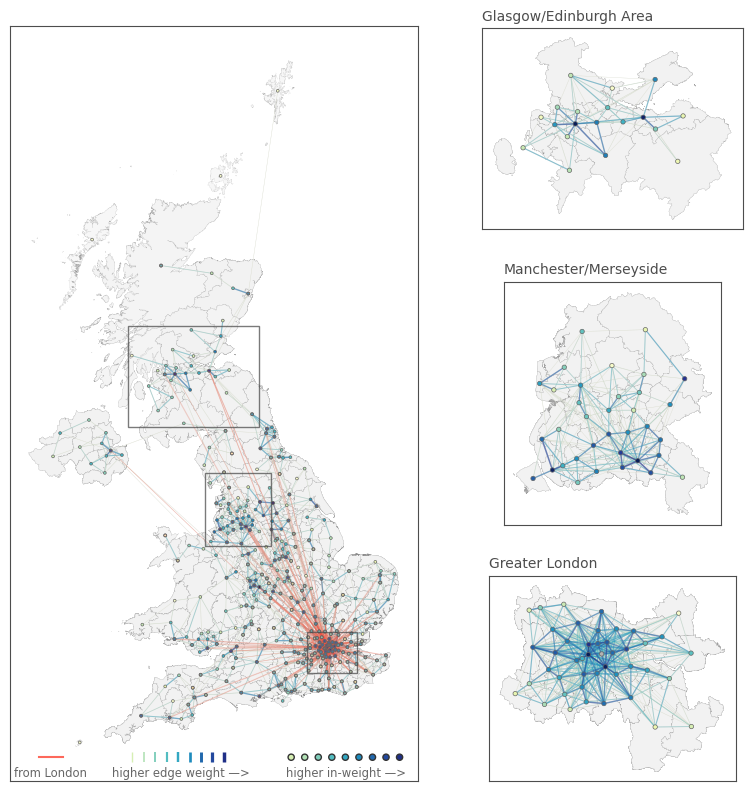

In [8]:
col = '#FD685B'
colX = [0.992, 0.318, 0.259, 0.9]

cmaa = plt.cm.YlGnBu_r
wx = 57
wi = uk_df['week_of'].unique()[wx]
w = 10; h = 10
fig = plt.figure(figsize=(w,h),dpi=100)

gs = GridSpec(6, 6, figure=fig, height_ratios=[0.6,1,1,1,1,0.6],
              width_ratios=[-0.45,2,1,1,1,1])

ax00 = fig.add_subplot(gs[0:6, 0:4])
ax04 = fig.add_subplot(gs[0:2, 4:6])
ax03 = fig.add_subplot(gs[2:4, 4:6])
ax02 = fig.add_subplot(gs[4:6, 4:6])

mov_gw = uk_df.loc[uk_df['week_of']==wi].copy()
mov_gw['sizes'] = (np.log(mov_gw['movement'])-np.log(mov_gw['movement']).min()+1).values

uk_shp = gdf.copy()
uk_shp = uk_shp.merge(mov_gw[['origin','sizes']], how='left', on='origin')

lo_shp = uk_shp.loc[uk_shp['origin'].isin(london_ix)].copy()
ma_shp = uk_shp.loc[uk_shp['origin'].isin(manchester_ix)].copy()
sc_shp = uk_shp.loc[uk_shp['origin'].isin(scotland_ix)].copy()

uk_map = uk_shp.plot(ax=ax00, fc='.95', ec='.55', lw=0.1, alpha=0.6,zorder=0)
lo_map = lo_shp.plot(ax=ax02, fc='.95', ec='.55', lw=0.1, alpha=0.6)
ma_map = ma_shp.plot(ax=ax03, fc='.95', ec='.55', lw=0.1, alpha=0.6)
sc_map = sc_shp.plot(ax=ax04, fc='.95', ec='.55', lw=0.1, alpha=0.6)

pos_mun = {gdf['origin'].values[i]:(gdf['centroid'].values[i].x, 
                                    gdf['centroid'].values[i].y)
           for i in range(gdf.shape[0])}

G_ref = nx.DiGraph()
G_ref.add_nodes_from(mun_nodes)
wel_ref = [(mov_gw['origin'].values[i],
            mov_gw['destination'].values[i],
            mov_gw['movement'].values[i]) for i in range(mov_gw.shape[0])]
G_ref.add_weighted_edges_from(wel_ref)
G_ref_rl = nx.relabel_nodes(G_ref, mun_relabel)

# for each week's network, let's get the Infomap communities
partition_informap_ref = get_infomap_communities(G_ref_rl)
partition_informap_ref = {relabel_mun[i]:j
                          for i,j in partition_informap_ref.items()}
Gcc_w = G_ref.to_undirected()

nsb = 5
tmp_nc = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                       for i in list(G_ref.edges(data=True))],
                      columns=['origin','destination','movement'])
ncw_df = tmp_nc.groupby('destination').agg({'movement':'sum'}).reset_index()
ncw = dict(zip(ncw_df['destination'].values,ncw_df['movement'].values))
nc_w = np.array(list(ncw.values()))
ncw_w = np.log(nc_w) - np.quantile(np.log(nc_w),.2) + 1
ncw_w[ncw_w<0] = 0
ncw_w = cmaa(((np.nanmax(ncw_w)-ncw_w)/(np.nanmax(ncw_w)-np.nanmin(ncw_w)))-0.05)
ncw = dict(zip(ncw_df['destination'].values,ncw_w))
ncw = {i:ncw[i] if i in list(ncw.keys()) else '.8' for i in list(Gcc_w.nodes())}

nc_w = [ncw[i] for i in list(Gcc_w.nodes())]
ns_w = [nsb-1 for i in list(Gcc_w.nodes())]

tmp_ew = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                       for i in list(Gcc_w.edges(data=True))],
                      columns=['origin','destination','movement'])
tmp_ew = tmp_ew.sort_values('movement').reset_index().iloc[:,1:]
ord_el = list(zip(tmp_ew['origin'].values,tmp_ew['destination'].values))

ew_dict = nx.get_edge_attributes(Gcc_w, 'weight')
ew_dict = {i:ew_dict[i] for i in ord_el}
ew_w = np.array(list(ew_dict.values()))
alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
alphs = alphs / max(alphs) / 1.5 + 0.125
ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
# ews_w = ews_w / max(ews_w) * 1.5 + 0.1
ews_w = ews_w / 12 * 1.5 + 0.1
ecs_w = cmaa(((np.nanmax(ews_w)-ews_w)/(np.nanmax(ews_w)-np.nanmin(ews_w)))-0.1)
ecs_wl = []
for ei,ec_i in enumerate(ecs_w):
    ec_i[-1] = alphs[ei]
    ecs_wl.append(ec_i)   

ecs_w = ecs_wl
nodes = nx.draw_networkx_nodes(Gcc_w, pos_mun, node_size=ns_w, linewidths=0.5, 
                       node_color=nc_w, edgecolors='.4', ax=ax00)
edges1 = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                               edge_color='.85', ax=ax00)
edges = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                               edge_color=ecs_w, ax=ax00)

london_ixL = uk_df.loc[uk_df['origin'].isin(london_ix)]['destination'].unique()
G_lon = nx.subgraph(G_ref, london_ixL)
lon_el = [i for i in G_lon.edges() if i[0] in london_ix or i[1] in london_ix]
ew_dict = {i:j for i,j in nx.get_edge_attributes(G_lon, 'weight').items()
           if i in lon_el or (i[1],i[0]) in lon_el}

lon_el = [i for i in G_lon.edges() if i[0] in london_ix or i[1] in london_ix]
G_lon = nx.subgraph(Gcc_w, london_ixL)
ew_dict = {i:j for i,j in nx.get_edge_attributes(G_lon, 'weight').items() if i in lon_el}
ew_w = np.array(list(ew_dict.values()))
alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
alphs = alphs / max(alphs) / 1.5 + 0.125
ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
# ews_w = ews_w / max(ews_w) * 1.5 + 0.1
ews_w = ews_w / 12 * 1.5 + 0.1
ecs_w = [colX for i in ews_w]
ecs_wl = []
for ei,ec_i in enumerate(ecs_w):
    ec_i[-1] = alphs[ei]/1.25
    ecs_wl.append(ec_i)   

ecs_w = ecs_wl
edgesL = nx.draw_networkx_edges(G_lon, pos_mun, edgelist=lon_el,
                                width=ews_w, edge_color=ecs_w, ax=ax00)
nodesL = nx.draw_networkx_nodes(G_lon, pos_mun, node_size=5, linewidths=0.5,
           node_color=[colX]*G_lon.number_of_nodes(), edgecolors='.4', ax=ax00)


nodes.set_zorder(20000)
nodesL.set_zorder(20002)
edges1.set_zorder(18)
edges.set_zorder(19)
edgesL.set_zorder(20)

axcols = ['.3','.3','.3']
axes00 = [ax02,ax03,ax04]
axtits = ['Greater London','Manchester/Merseyside','Glasgow/Edinburgh Area']

lo_cou = lo_shp['origin'].unique()
ma_cou = ma_shp['origin'].unique()
sc_cou = sc_shp['origin'].unique()
axcous = [lo_cou, ma_cou, sc_cou]

for ai,a in enumerate(axes00):
    ylims_a = a.get_ylim()
    xlims_a = a.get_xlim()

    a.set_title(axtits[ai], ha='left',x=0, fontsize='medium', color=axcols[ai])
    ax00.add_patch(Rectangle((xlims_a[0], ylims_a[0]),
                              xlims_a[1] - xlims_a[0], ylims_a[1] - ylims_a[0],
                alpha=0.75, facecolor='None', ec=axcols[ai], lw=1.0, zorder=50000))

    for l in ['bottom','top','left','right']:
        a.spines[l].set_color(axcols[ai])

    df_w = uk_df_ref.loc[(uk_df_ref['origin'].isin(axcous[ai]))&\
                         (uk_df_ref['destination'].isin(axcous[ai]))].copy()
    G_w = nx.DiGraph()
    G_w.add_nodes_from(axcous[ai])
    wel_w = [(df_w['origin'].values[i],
              df_w['destination'].values[i],
              df_w['movement'].values[i]) for i in range(df_w.shape[0])]
    G_w.add_weighted_edges_from(wel_w)
    Gcc_w = G_w.to_undirected()

    nsb = 10
    tmp_nc = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                           for i in list(G_w.edges(data=True))],
                          columns=['origin','destination','movement'])
    ncw_df = tmp_nc.groupby('destination').agg({'movement':'sum'}).reset_index()
    ncw = dict(zip(ncw_df['destination'].values,ncw_df['movement'].values))
    nc_w = np.array(list(ncw.values()))
    ncw_w = np.log(nc_w) - np.quantile(np.log(nc_w),.2) + 1
    ncw_w[ncw_w<0] = 0
    ncw_w = cmaa(((np.nanmax(ncw_w)-ncw_w)/(np.nanmax(ncw_w)-np.nanmin(ncw_w)))-0.05)
    ncw = dict(zip(ncw_df['destination'].values,ncw_w))
    ncw = {i:ncw[i] if i in list(ncw.keys()) else '.7' for i in list(Gcc_w.nodes())}
    nc_w = [ncw[i] for i in list(Gcc_w.nodes())]
    ns_w = [nsb for i in list(Gcc_w.nodes())]

    tmp_ew = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                           for i in list(Gcc_w.edges(data=True))],
                          columns=['origin','destination','movement'])
    tmp_ew = tmp_ew.sort_values('movement').reset_index().iloc[:,1:]
    ord_el = list(zip(tmp_ew['origin'].values,tmp_ew['destination'].values))

    ew_dict = nx.get_edge_attributes(Gcc_w, 'weight')
    ew_dict = {i:ew_dict[i] for i in ord_el}
    ew_w = np.array(list(ew_dict.values()))
    alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
    alphs = alphs / max(alphs) / 1.5 + 0.125
    ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
    # ews_w = ews_w / max(ews_w) * 1.5 + 0.1
    ews_w = ews_w / 12 * 1.5 + 0.1
    ecs_w = cmaa(((np.nanmax(ews_w)-ews_w)/(np.nanmax(ews_w)-np.nanmin(ews_w)))-0.1)
    ecs_wl = []
    for ei,ec_i in enumerate(ecs_w):
        ec_i[-1] = alphs[ei]
        ecs_wl.append(ec_i)   

    ecs_w = ecs_wl
    nodes = nx.draw_networkx_nodes(Gcc_w, pos_mun, node_size=ns_w, linewidths=0.5, 
                           node_color=nc_w, edgecolors='.4', ax=a)
    edges1 = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                                   edge_color='.85', ax=a)
    edges = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                                   edge_color=ecs_w, ax=a)

    nodes.set_zorder(20000)
    edges1.set_zorder(19)
    edges.set_zorder(19)

ax00_sub = ax00.inset_axes([0, 0, 1, 0.045])
ax00_sub.vlines(np.linspace(0.3,0.525,9), 0.55, 0.85,
                color=cmaa(np.linspace(0.8,0.1,9)),
                lw=np.linspace(1, 2.5, 9))
ax00_sub.text(0.42, 0.05, 'higher edge weight —>', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.scatter(np.linspace(0.69,0.956,9), [0.7]*9,
                c=cmaa(np.linspace(0.8,0.1,9)),ec='.2',s=20)
ax00_sub.text(0.825, 0.05, 'higher in-weight —>', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.plot([0.07,0.13], [0.7,.7],
               color=col,lw=1.5)
ax00_sub.text(0.1, 0.05, 'from London', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.set_xlim(0,1)
ax00_sub.set_ylim(0,1)
ax00_sub.set_axis_off()

for l in ['bottom','top','left','right']:
    ax00.spines[l].set_color(axcols[ai])


for a in fig.axes:
    a.set_xticks([])
    a.set_yticks([])

plt.subplots_adjust(hspace=0.6,wspace=0.2)

# plt.savefig('pdfs/weekly_uk_%s_main_noraster.pdf'%wi,dpi=425,bbox_inches='tight')
plt.show()

# Step 4: Plot weekly UK networks (e.g. below)

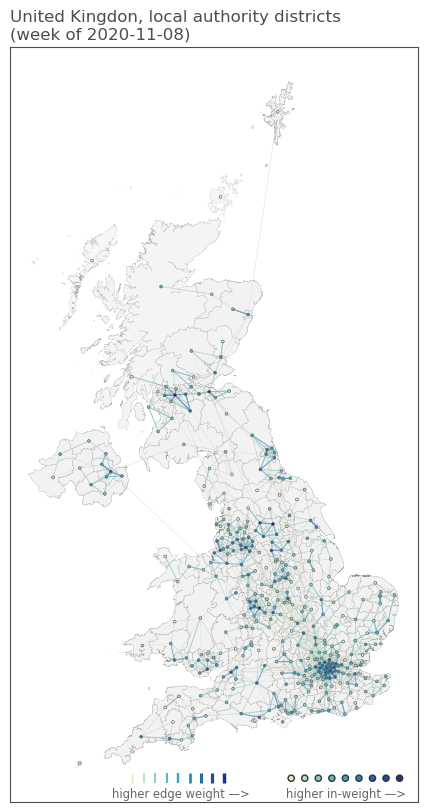

In [9]:
wx = 54
wi = uk_df['week_of'].unique()[wx]

fig, ax = plt.subplots(1,1,figsize=(w,h),dpi=100)

ax.set_title('United Kingdon, local authority districts\n(week of %s)'%wi,
           ha='left',x=0, fontsize='large', color='.3')

mov_gw = uk_df.loc[uk_df['week_of']==wi].copy()
mov_gw['sizes'] = (np.log(mov_gw['movement'])-np.log(mov_gw['movement']).min()+1).values

uk_shp = gdf.copy()
uk_shp = uk_shp.merge(mov_gw[['origin','sizes']], how='left', on='origin')

lo_shp = uk_shp.loc[uk_shp['origin'].isin(london_ix)].copy()
ma_shp = uk_shp.loc[uk_shp['origin'].isin(manchester_ix)].copy()
sc_shp = uk_shp.loc[uk_shp['origin'].isin(scotland_ix)].copy()

uk_map = uk_shp.plot(ax=ax, fc='.95', ec='.55', lw=0.1, alpha=0.6,zorder=0)
uk_map.set_rasterized(True)

pos_mun = {gdf['origin'].values[i]:(gdf['centroid'].values[i].x,
                                    gdf['centroid'].values[i].y)
           for i in range(gdf.shape[0])}

G_ref = nx.DiGraph()
G_ref.add_nodes_from(mun_nodes)
wel_ref = [(mov_gw['origin'].values[i],
            mov_gw['destination'].values[i],
            mov_gw['movement'].values[i]) for i in range(mov_gw.shape[0])]
G_ref.add_weighted_edges_from(wel_ref)
G_ref_rl = nx.relabel_nodes(G_ref, mun_relabel)

# for each week's network, let's get the Infomap communities
partition_informap_ref = get_infomap_communities(G_ref_rl)
partition_informap_ref = {relabel_mun[i]:j
                          for i,j in partition_informap_ref.items()}
Gcc_w = G_ref.to_undirected()

nsb = 5
tmp_nc = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                       for i in list(G_ref.edges(data=True))],
                      columns=['origin','destination','movement'])
ncw_df = tmp_nc.groupby('destination').agg({'movement':'sum'}).reset_index()
ncw = dict(zip(ncw_df['destination'].values,ncw_df['movement'].values))
nc_w = np.array(list(ncw.values()))
ncw_w = np.log(nc_w) - np.quantile(np.log(nc_w),.2) + 1
ncw_w[ncw_w<0] = 0
ncw_w = cmaa(((np.nanmax(ncw_w)-ncw_w)/(np.nanmax(ncw_w)-np.nanmin(ncw_w)))-0.05)
ncw = dict(zip(ncw_df['destination'].values,ncw_w))
ncw = {i:ncw[i] if i in list(ncw.keys()) else '.8' for i in list(Gcc_w.nodes())}

nc_w = [ncw[i] for i in list(Gcc_w.nodes())]
ns_w = [nsb-1 for i in list(Gcc_w.nodes())]

tmp_ew = pd.DataFrame([[i[0],i[1],i[2]['weight']]
                       for i in list(Gcc_w.edges(data=True))],
                      columns=['origin','destination','movement'])
tmp_ew = tmp_ew.sort_values('movement').reset_index().iloc[:,1:]
ord_el = list(zip(tmp_ew['origin'].values,tmp_ew['destination'].values))

ew_dict = nx.get_edge_attributes(Gcc_w, 'weight')
ew_dict = {i:ew_dict[i] for i in ord_el}
ew_w = np.array(list(ew_dict.values()))
alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
alphs = alphs / max(alphs) / 1.5 + 0.125
ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
# ews_w = ews_w / max(ews_w) * 1.5 + 0.1
ews_w = ews_w / 12 * 1.5 + 0.1
ecs_w = cmaa(((np.nanmax(ews_w)-ews_w)/(np.nanmax(ews_w)-np.nanmin(ews_w)))-0.1)
ecs_wl = []
for ei,ec_i in enumerate(ecs_w):
    ec_i[-1] = alphs[ei]
    ecs_wl.append(ec_i)   

ecs_w = ecs_wl
nodes = nx.draw_networkx_nodes(Gcc_w, pos_mun, node_size=ns_w, linewidths=0.5, 
                       node_color=nc_w, edgecolors='.4', ax=ax)
edges1 = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                               edge_color='.85', ax=ax)
edges = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
                               edge_color=ecs_w, ax=ax)

nodes.set_zorder(20000)
edges1.set_zorder(18)
edges.set_zorder(19)

ax00_sub = ax.inset_axes([0, 0, 1, 0.045])
ax00_sub.vlines(np.linspace(0.3,0.525,9), 0.55, 0.85,
                color=cmaa(np.linspace(0.8,0.1,9)),
                lw=np.linspace(1, 2.5, 9))
ax00_sub.text(0.42, 0.05, 'higher edge weight —>', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.scatter(np.linspace(0.69,0.956,9), [0.7]*9,
                c=cmaa(np.linspace(0.8,0.1,9)),ec='.2',s=20)
ax00_sub.text(0.825, 0.05, 'higher in-weight —>', fontsize='small',
              color='.4', ha='center', va='bottom')

ax00_sub.set_xlim(0,1)
ax00_sub.set_ylim(0,1)
ax00_sub.set_axis_off()

for l in ['bottom','top','left','right']:
    ax.spines[l].set_color(axcols[ai])


for a in fig.axes:
    a.set_xticks([])
    a.set_yticks([])

# plt.savefig('pngs/weekly_uk_%s.png'%wi,dpi=425,bbox_inches='tight')
# plt.savefig('pdfs/weekly_uk_%s.pdf'%wi,dpi=425,bbox_inches='tight')
plt.show()

### (uncomment to span thru all weeks()

In [10]:
# cmaa = plt.cm.YlGnBu_r
# w = 6
# h = 10
# for wx, wi in enumerate(uk_df['week_of'].unique()):
#     fig, ax = plt.subplots(1,1,figsize=(w,h),dpi=100)

#     ax.set_title('United Kingdon, local authority districts\n(week of %s)'%wi,
#                ha='left',x=0, fontsize='large', color='.3')

#     mov_gw = uk_df.loc[uk_df['week_of']==wi].copy()
#     mov_gw['sizes'] = (np.log(mov_gw['movement'])-\
#                        np.log(mov_gw['movement']).min()+1).values

#     uk_shp = gdf.copy()
#     uk_shp = uk_shp.merge(mov_gw[['origin','sizes']], how='left', on='origin')

#     lo_shp = uk_shp.loc[uk_shp['origin'].isin(london_ix)].copy()
#     ma_shp = uk_shp.loc[uk_shp['origin'].isin(manchester_ix)].copy()
#     sc_shp = uk_shp.loc[uk_shp['origin'].isin(scotland_ix)].copy()

#     uk_map = uk_shp.plot(ax=ax, fc='.95', ec='.55', lw=0.1, alpha=0.6,zorder=0)
#     uk_map.set_rasterized(True)

#     pos_mun = {gdf['origin'].values[i]:(gdf['centroid'].values[i].x,
#                                         gdf['centroid'].values[i].y)
#                for i in range(gdf.shape[0])}

#     G_ref = nx.DiGraph()
#     G_ref.add_nodes_from(mun_nodes)
#     wel_ref = [(mov_gw['origin'].values[i],
#                 mov_gw['destination'].values[i],
#                 mov_gw['movement'].values[i]) for i in range(mov_gw.shape[0])]
#     G_ref.add_weighted_edges_from(wel_ref)
#     G_ref_rl = nx.relabel_nodes(G_ref, mun_relabel)

#     # for each week's network, let's get the Infomap communities
#     partition_informap_ref = get_infomap_communities(G_ref_rl)
#     partition_informap_ref = {relabel_mun[i]:j
#                               for i,j in partition_informap_ref.items()}
#     Gcc_w = G_ref.to_undirected()

#     nsb = 5
#     tmp_nc = pd.DataFrame([[i[0],i[1],i[2]['weight']]
#                            for i in list(G_ref.edges(data=True))],
#                           columns=['origin','destination','movement'])
#     ncw_df = tmp_nc.groupby('destination').agg({'movement':'sum'}).reset_index()
#     ncw = dict(zip(ncw_df['destination'].values,ncw_df['movement'].values))
#     nc_w = np.array(list(ncw.values()))
#     ncw_w = np.log(nc_w) - np.quantile(np.log(nc_w),.2) + 1
#     ncw_w[ncw_w<0] = 0
#     ncw_w = cmaa(((np.nanmax(ncw_w)-ncw_w)/(np.nanmax(ncw_w)-np.nanmin(ncw_w)))-0.05)
#     ncw = dict(zip(ncw_df['destination'].values,ncw_w))
#     ncw = {i:ncw[i] if i in list(ncw.keys()) else '.8' for i in list(Gcc_w.nodes())}

#     nc_w = [ncw[i] for i in list(Gcc_w.nodes())]
#     ns_w = [nsb-1 for i in list(Gcc_w.nodes())]

#     tmp_ew = pd.DataFrame([[i[0],i[1],i[2]['weight']]
#                            for i in list(Gcc_w.edges(data=True))],
#                           columns=['origin','destination','movement'])
#     tmp_ew = tmp_ew.sort_values('movement').reset_index().iloc[:,1:]
#     ord_el = list(zip(tmp_ew['origin'].values,tmp_ew['destination'].values))

#     ew_dict = nx.get_edge_attributes(Gcc_w, 'weight')
#     ew_dict = {i:ew_dict[i] for i in ord_el}
#     ew_w = np.array(list(ew_dict.values()))
#     alphs = (np.log(ew_w)-min(np.log(ew_w))+1)
#     alphs = alphs / max(alphs) / 1.5 + 0.125
#     ews_w = np.log(ew_w) - min(np.log(ew_w)) + 1
#     # ews_w = ews_w / max(ews_w) * 1.5 + 0.1
#     ews_w = ews_w / 12 * 1.5 + 0.1
#     ecs_w = cmaa(((np.nanmax(ews_w)-ews_w)/(np.nanmax(ews_w)-np.nanmin(ews_w)))-0.1)
#     ecs_wl = []
#     for ei,ec_i in enumerate(ecs_w):
#         ec_i[-1] = alphs[ei]
#         ecs_wl.append(ec_i)   

#     ecs_w = ecs_wl
#     nodes = nx.draw_networkx_nodes(Gcc_w, pos_mun, node_size=ns_w, linewidths=0.5, 
#                            node_color=nc_w, edgecolors='.4', ax=ax)
#     edges1 = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
#                                    edge_color='.85', ax=ax)
#     edges = nx.draw_networkx_edges(Gcc_w, pos_mun, edgelist=ord_el, width=ews_w,
#                                    edge_color=ecs_w, ax=ax)

#     nodes.set_zorder(20000)
#     edges1.set_zorder(18)
#     edges.set_zorder(19)

#     ax00_sub = ax.inset_axes([0, 0, 1, 0.045])
#     ax00_sub.vlines(np.linspace(0.3,0.525,9), 0.55, 0.85,
#                     color=cmaa(np.linspace(0.8,0.1,9)),
#                     lw=np.linspace(1, 2.5, 9))
#     ax00_sub.text(0.42, 0.05, 'higher edge weight —>', fontsize='small',
#                   color='.4', ha='center', va='bottom')

#     ax00_sub.scatter(np.linspace(0.69,0.956,9), [0.7]*9,
#                     c=cmaa(np.linspace(0.8,0.1,9)),ec='.2',s=20)
#     ax00_sub.text(0.825, 0.05, 'higher in-weight —>', fontsize='small',
#                   color='.4', ha='center', va='bottom')

#     ax00_sub.set_xlim(0,1)
#     ax00_sub.set_ylim(0,1)
#     ax00_sub.set_axis_off()

#     for l in ['bottom','top','left','right']:
#         ax.spines[l].set_color(axcols[ai])


#     for a in fig.axes:
#         a.set_xticks([])
#         a.set_yticks([])

# #     plt.savefig('pngs/weekly_uk_%s.png'%wi,dpi=425,bbox_inches='tight')
# #     plt.savefig('pdfs/weekly_uk_%s.pdf'%wi,dpi=425,bbox_inches='tight')
#     plt.close()

# Step 5: Plot overall change in movement

In [11]:
uk_dfg_avg = uk_df.loc[(uk_df['origin']!=uk_df['destination'])&\
                   (uk_df['week'].isin(ref_weeks))                   
                  ].agg({'converted_movements':'mean',
                                  'movement':'mean'})


uk_dfg = uk_df.loc[uk_df['origin']!=uk_df['destination']
                  ].groupby(['week_of']).agg({'converted_movements':'sum',
                                              'movement':'sum'}).reset_index()

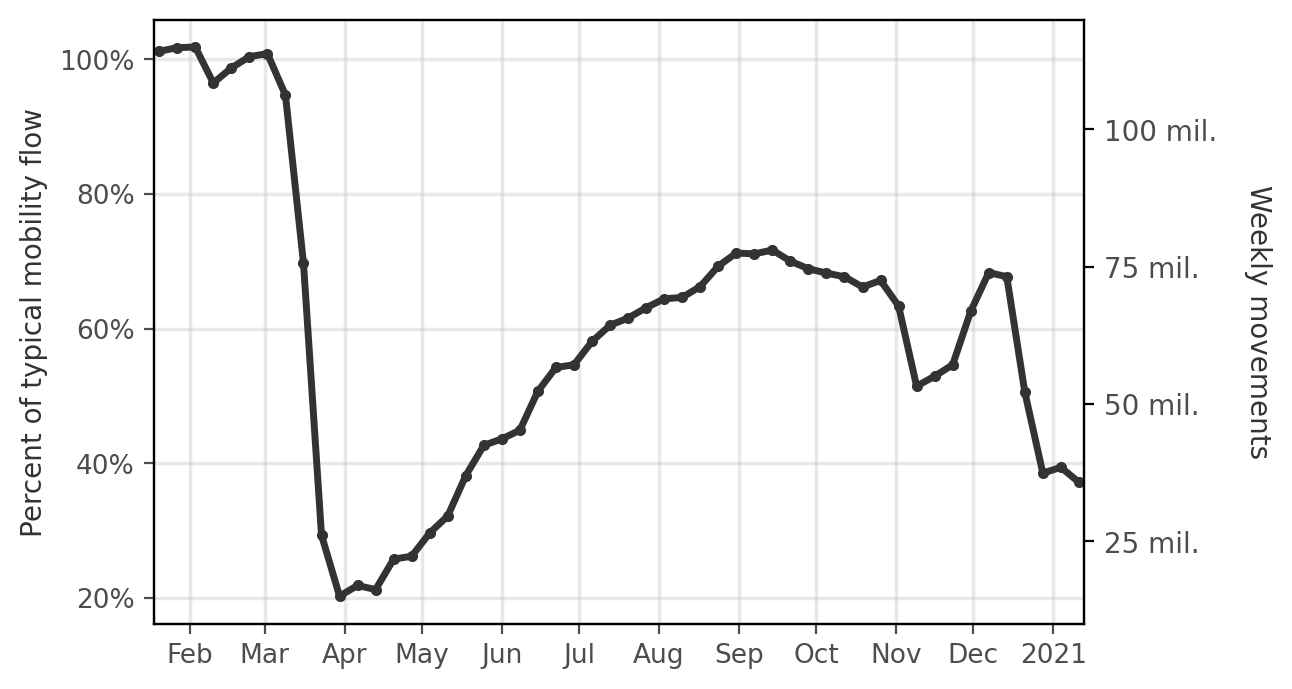

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=200)

ax.plot([date_dict[i] for i in uk_dfg['week_of'].values[12:]],
         uk_dfg['converted_movements'].values[12:]/\
         np.mean(uk_dfg['converted_movements'].values[12:17]), lw=2.5,
        marker='.', color='.2')

dates_tt = ['2020-02-01','2020-03-01','2020-04-01',
            '2020-05-01','2020-06-01','2020-07-01','2020-08-01',
            '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01']
dates_ll = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
            'Sep', 'Oct', 'Nov', 'Dec', '2021']
ax.set_xticks([date_dict[i] for i in dates_tt])
ax.set_xticklabels(dates_ll, fontsize=9.5)
ax.set_xlim(date_dict['2020-01-17'],date_dict['2021-01-12'])
ax.set_ylabel('Percent of typical mobility flow', color='.2')

ax.set_yticks(np.linspace(0.2,1,5))
ax.set_yticklabels(['20%','40%','60%','80%','100%'], fontsize=9.5)
ax.grid(lw=1.5, color='.75', alpha=0.25)
ax.tick_params(labelcolor='.3', color='.3')
ax.grid(linewidth=1.25,color='.75',alpha=0.35)
ax2 = ax.twinx()
ax2.set_yticks([25, 50, 75, 100])
ax2.set_yticklabels(['25 mil.','50 mil.','75 mil.','100 mil.'], color='.3')
ax2.set_ylim(10, 120)
ax2.set_ylabel('Weekly movements', color='.2', rotation=270, labelpad=20)


# plt.savefig(fnp+'pngs/mobility_uk_nationwide.png',dpi=425,bbox_inches='tight')
# plt.savefig(fnp+'pdfs/mobility_uk_nationwide.pdf',bbox_inches='tight')
# plt.savefig('../figs/pngs/mobility_uk_nationwide.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/mobility_uk_nationwide.pdf',bbox_inches='tight')
plt.show()

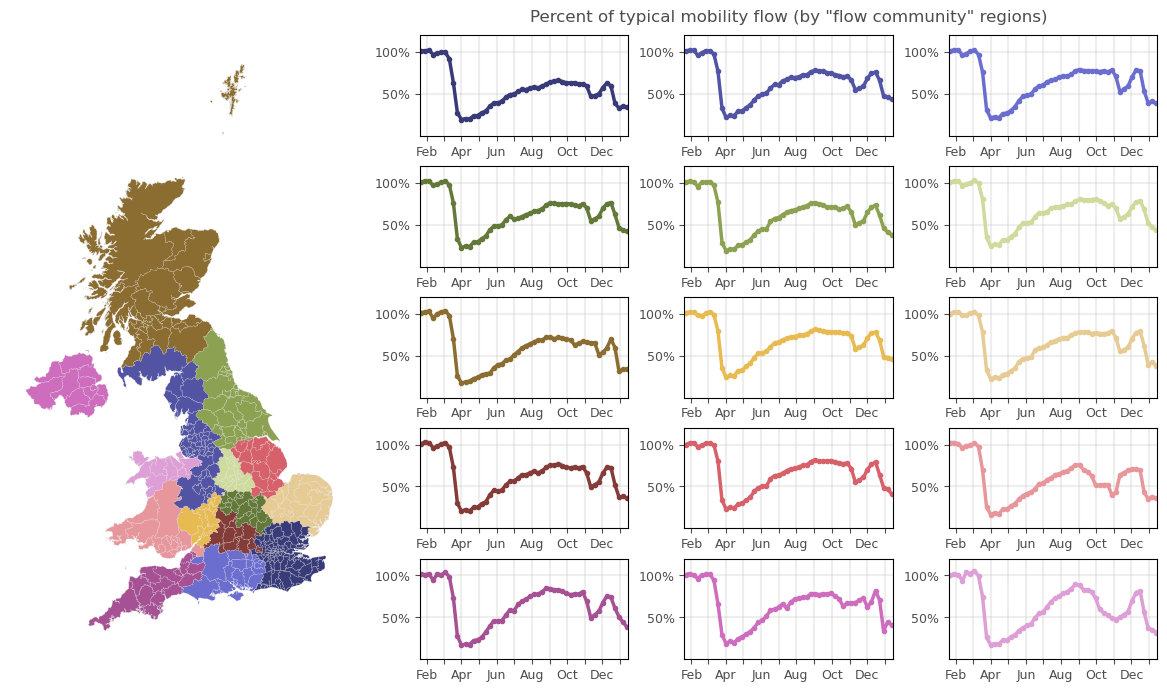

In [13]:
w = 15; h = 10
fig = plt.figure(figsize=(w,h),dpi=100)
gs = GridSpec(6, 5, figure=fig, width_ratios=[1,0.5,1,1,1])

ax00 = fig.add_subplot(gs[0:5, 0:2])
ax11 = fig.add_subplot(gs[0, 2])
ax12 = fig.add_subplot(gs[0, 3])
ax13 = fig.add_subplot(gs[0, 4])
ax21 = fig.add_subplot(gs[1, 2])
ax22 = fig.add_subplot(gs[1, 3])
ax23 = fig.add_subplot(gs[1, 4])
ax31 = fig.add_subplot(gs[2, 2])
ax32 = fig.add_subplot(gs[2, 3])
ax33 = fig.add_subplot(gs[2, 4])
ax41 = fig.add_subplot(gs[3, 2])
ax42 = fig.add_subplot(gs[3, 3])
ax43 = fig.add_subplot(gs[3, 4])
ax51 = fig.add_subplot(gs[4, 2])
ax52 = fig.add_subplot(gs[4, 3])
ax53 = fig.add_subplot(gs[4, 4])

axs = [ax11, ax12, ax13, 
       ax21, ax22, ax23, 
       ax31, ax32, ax33, 
       ax41, ax42, ax43, 
       ax51, ax52, ax53]

dates_tt = ['2020-02-01','2020-03-01','2020-04-01',
            '2020-05-01','2020-06-01','2020-07-01','2020-08-01',
            '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01']
dates_ll = ['Feb', '', 'Apr', '', 'Jun', '', 'Aug',
            '', 'Oct', '', 'Dec', '']
cols = plt.cm.tab20b(np.linspace(0, 1, gdfx['comm'].nunique()))
for i, a in enumerate(axs):
    comm_i = gdfx.loc[gdfx['comm']==i].copy()
    uk_df_c = uk_df.loc[uk_df['origin'].isin(comm_i['origin'].unique())].copy()
    uk_dfg_c = uk_df_c.loc[uk_df_c['origin']!=uk_df_c['destination']
                      ].groupby(['week_of']).agg({'converted_movements':'sum',
                                          'movement':'sum'}).reset_index()    

    a.plot([date_dict[i] for i in uk_dfg_c['week_of'].values[12:]],
         uk_dfg_c['converted_movements'].values[12:]/\
         np.mean(uk_dfg_c['converted_movements'].values[12:17]), lw=2.5,
        marker='.', color=cols[i])
    a.set_ylim(0, 1.2)
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels(dates_ll, fontsize=9)
    a.set_xlim(date_dict['2020-01-17'],date_dict['2021-01-12'])

    a.set_yticks([.5,1])
    a.set_yticklabels(['50%','100%'], fontsize=9)
    a.grid(lw=1.5, color='.75', alpha=0.25)
    a.tick_params(labelcolor='.3', color='.3')

gdfx.plot(ax=ax00, column='comm', cmap='tab20b', lw=0.1, ec='.9')
ax00.set_axis_off()
ax12.set_title('Percent of typical mobility flow (by "flow community" regions)',
               color='.3', y=1.05)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

# plt.savefig(fnp+'pngs/mobility_uk_regions.png',dpi=425,bbox_inches='tight')
# plt.savefig(fnp+'pdfs/mobility_uk_regions.pdf',bbox_inches='tight')
# plt.savefig('../figs/pngs/mobility_uk_regions.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/mobility_uk_regions.pdf',bbox_inches='tight')

plt.show()

# That's all for now!

_____________